# Análisis, limpieza y transformación de los datos básicos de empresas
El siguiente cuaderno es el punto de partida del desarrollo del proyecto. A través de una lista de cuadernos, se llevan a cabo todas las actividades del desarrollo, y se complementan con las explicaciones sobre las hipótesis, resultados, y decisiones tomadas a lo largo de la ejecución.

En primer lugar, se realiza el análisis, la limpieza y la transformación de datos de la fuente "DatosEmpresa". Esta fuente contienen información básica sobre las empresas en Colombia. Por ejemplo el número de empleados, la denominación de tamaño de la empresa según el reglamento colombiano, el sector...

Los datos son una extracción realizada por Santiago Rojo, el director del proyecto, a través de la información pública disponible en las distintas superintendencias de Colombia. Las empresas han sido anonimizadas y únicamente se identifican por un número arbitrario.

El proyecto también contempla el dataset de ejercicios fiscales de las empresas, pero se procesa en otro cuaderno.

El dataset de datos básicos contiene un total de 8 columnas:

* Id: Identificador de la empresa. Es un número único para cada empresa.
* Tipologia: tipo de empresa, como por ejemplo sociedad comercial o entidad sin ánimo de lucro.
* Ciiu: [código ciiu](https://www.gerencie.com/codigos-ciiu.html) de la actividad principal de la empresa.
* Sociedad: [tipo de sociedad](https://jlcauditors.com/cuales-tipos-sociedades-colombia/) en Colombia.
* Tamanyo: denominación de tamaño de la empresa según decreto.
* Departamento: departamento de la empresa (unidad territorial en Colombia).
* Localidad: municipio concreto de la empresa.
* NumEmpleados: número de empleados de la empresa (2019).
* AnyoConstitucion: año de constitución de la empresa.

## Análisis preliminar
En primer lugar, se analizan las variables y su distribución:

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import unidecode
import matplotlib as mpl

In [23]:
# Obtener los datos del fichero fuente
basicos = pd.read_excel('data/DatosEmpresa.xls', names=['Id','Tipologia','Ciiu','Sociedad','Tamanyo',\
                        'Departamento','Localidad','NumEmpleados','AnyoConstitucion'])

# Mostrar las columnas, su tipo de datos, y el número de celdas perdidas
basicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                13357 non-null  int64  
 1   Tipologia         13357 non-null  object 
 2   Ciiu              13357 non-null  object 
 3   Sociedad          13357 non-null  object 
 4   Tamanyo           13357 non-null  object 
 5   Departamento      13357 non-null  object 
 6   Localidad         13357 non-null  object 
 7   NumEmpleados      13040 non-null  float64
 8   AnyoConstitucion  13350 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 939.3+ KB


Se observa que:

* Solo las columnas NumEmpleados y AnyoConstitucion contienen valores perdidos. Esto son las empresas cuya fecha de constitución y/o número de empleados no son conocidos.
* El resto de columnas no contienen valores perdidos.

### Variables numéricas
Para empezar, se observan los estadísticos básicos y las distribuciones de las variables numéricas.

In [24]:
# Describir los datos básicos numéricos
basicos.describe()

,Id,NumEmpleados,AnyoConstitucion
count,1.335700e+04,13040.000000,13350.000000
mean,1.382476e+09,194.206902,1996.058951
std,5.063684e+09,794.448365,14.993285
min,2.331510e+05,1.000000,1875.000000
25%,6.932400e+05,10.000000,1988.000000
50%,2.742966e+06,40.000000,1999.000000
75%,1.164011e+08,123.000000,2008.000000
max,2.158508e+10,36757.000000,2017.000000


El número de empleados tiene un valor máximo mucho más grande que su media. La causa son las empresas más grandes del país, que tienen un número de empleados anormalmente grande.

Para poder observar la distribución de la variable de forma efectiva, se filtran aquellas empresas con un número de empleados superior a 1000.

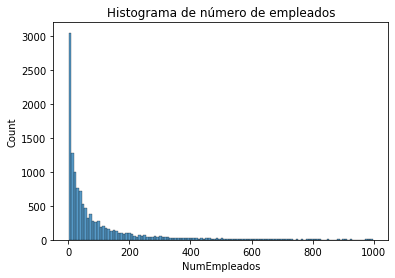

La moda de la variable es: 1.0 


In [25]:
# Observar el histograma del número de empleados filtrando las empresas de tamaño grande
#fig = plt.figure(figsize=(1,1))
sns.histplot(data=basicos[basicos['NumEmpleados'] < 1000], x="NumEmpleados")
plt.title("Histograma de número de empleados")
plt.show()
print("La moda de la variable es: {0} ".format(basicos['NumEmpleados'].mode()[0]))

La distribución se asemeja a la exponencial, lo que indica que a mayor tamaño de empresa, menor frecuencia de aparición. Esto significa que las empresas medianas y pequeñas representan la gran mayoría.

El mayor número de empleados es 1, lo que indica que la moda de la variable es representada por las empresas de 1 solo trabajador.

Para finalizar con las variables numéricas, se analiza el histograma del año de constitución de las empresas.

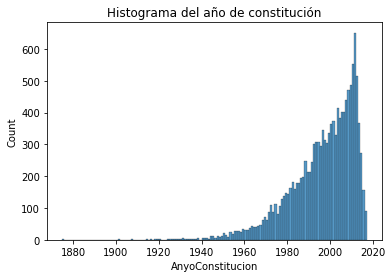

Moda del año de constitución: 2011.0


In [26]:
# Observar el histograma del año de constitución de la empresa. Se utilizan tantos contenedores como años en el dataset
sns.histplot(data=basicos, x="AnyoConstitucion", \
             bins=int(basicos['AnyoConstitucion'].max()-basicos['AnyoConstitucion'].min()))
plt.title("Histograma del año de constitución")
plt.show()
print("Moda del año de constitución: {}".format(basicos['AnyoConstitucion'].mode()[0]))

La distribución muestra un crecimiento prolongado y acelerado del número de empresas hasta el valor de la moda (2011). Después de esa fecha, la creación de empresas cae en picado con una pendiente muy pronunciada.

Esto se debe muy probablemente a un **desequilibrio** en los datos, ya que no hay ninguna fuente oficial que reporte dicha caída precipitada en la creación de empresas en Colombia. [Fuente](https://www.valoraanalitik.com/2021/01/24/creacion-de-empresas-en-colombia-cayo-94-en-2020-frente-al-2019/)

Aunque la fecha de creación de la empresa sea desequilibrada, no supone problema alguno si se utilizan ciertas definiciones de zombi, ya que requieren que las empresas tengan una antigüedad mínima fijada. Por ejemplo, la definición de EZ de la OECD requiere que la antigüedad de la empresa sea mayor a 10 años.

Aun así, otras definiciones sí que pueden utilizar estas empresas, por lo que será necesario tener presente este desequilibrio en posteriores análisis.

### Variables categóricas
Las variables categóricas de la fuente de datos sobrepasan las numéricas. La primera de ellas es el tamaño de la empresa. Según el decreto [957 de 2019](https://www.ccb.org.co/Inscripciones-y-renovaciones/Normativa-Registros-Publicos/Normatividad-Registro-Unico-de-Proponentes) de la cámara de comercio de Bogotá, el tamaño de una empresa se calcula en función de sus ingresos brutos, y se clasifica en las siguientes categorías:

* Microempresa (MC)
* Pequeña empresa (PQ)
* Mediana empresa (MD)
* Gran empresa (GR)

A continuación se observan la distribución de las categorías del tamaño de la empresa y la estimación del número de empleados de cada grupo mediante un barplot con intervalo de confianza del error en cada grupo.

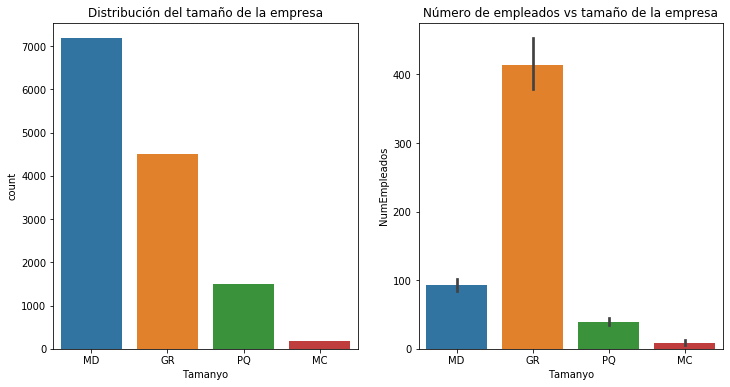

In [27]:
# Comparar los counts del tamaño de empresa y el número de empleados.
fig, axes = plt.subplots(1,2, figsize=(12,6))
sns.countplot(data=basicos,x="Tamanyo",ax=axes[0])
axes[0].set_title("Distribución del tamaño de la empresa")
sns.barplot(data=basicos,x="Tamanyo",y="NumEmpleados",ax=axes[1])
axes[1].set_title("Número de empleados vs tamaño de la empresa")
plt.show()

Estas visualizaciones confirman que a mayor número de empleados, mayor denominación de tamaño.

También se observa que las grandes empresas absorben una cantidad anormal de trabajadores respecto a los otros grupos. Los grupos más pequeños crecen de forma regular respecto al número de empleados, pero las empresas grandes presentan un salto enorme en ese número.

Siguiendo con otras variables, se muestra el conteo de categorías de la variable Tipologia.

In [28]:
basicos['Tipologia'].value_counts()

SOCIEDAD COMERCIAL/INDUSTRIAL    12854
ENTIDAD EXTRANJERA                 270
ENTIDAD SIN ANIMO DE LUCRO         137
EMPRESARIO INDIVIDUAL               85
SOCIEDAD NO COMERCIAL               11
Name: Tipologia, dtype: int64

El dataset está claramente dominado por las sociedades comerciales o industriales.

Los departamentos en Colombia son las distintas regiones que dividen el territorio del país. Existen un total de 32 departamentos, más el distrito capital, que se considera un departamento por sí mismo. Este departamento es la ciudad de Bogotá.

In [29]:
# Observar el número de departamentos del dataset y el conteo de elementos
print("Número total de departamentos: {0}".format(len(basicos['Departamento'].value_counts())))
print("Conto de departamentos:")
basicos['Departamento'].value_counts()

Número total de departamentos: 29
Conto de departamentos:


BOGOTA             6162
ANTIOQUIA          2221
VALLE              1114
CUNDINAMARCA        886
ATLANTICO           683
SANTANDER           485
BOLIVAR             273
RISARALDA           224
NORTE SANTANDER     148
CALDAS              142
MAGDALENA           141
META                108
TOLIMA              106
QUINDIO              86
HUILA                84
BOYACA               83
CAUCA                80
CORDOBA              73
NARINO               70
CESAR                58
CASANARE             47
SUCRE                32
CAQUETA              19
LA GUAJIRA           11
PUTUMAYO              7
AMAZONAS              5
CHOCO                 4
ARAUCA                3
VICHADA               2
Name: Departamento, dtype: int64

En la fuente de datos, no existe ninguna empresa en los departamentos de Vaupés, San Andrés, Guainía y Guaviare. Este hecho es esperable, ya que los departamentos en cuestión no disponen de demasiados municipios ni habitantes (con la excepción de San Andrés). [Fuente](https://es.wikipedia.org/wiki/Departamentos_de_Colombia)

También se pueden analizar las ciudades o localidades presentes en los datos. En este caso existen muchos más categorías, equivalentes al número de ciudades.

Número total de localidades: 263


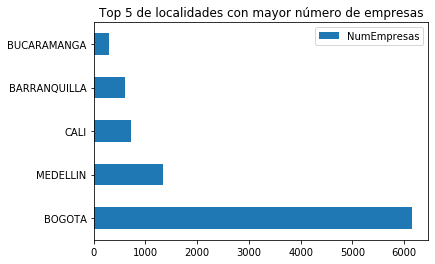

In [30]:
print("Número total de localidades: {0}".format(len(basicos['Localidad'].unique())))
top_localidad = pd.DataFrame(basicos['Localidad'].value_counts().head())
top_localidad = top_localidad.rename(columns={'Localidad':'NumEmpresas'})
top_localidad.plot(kind = 'barh')
plt.title("Top 5 de localidades con mayor número de empresas")
plt.show()

Y, por último, la variable del tipo de sociedad de la empresa. Se trata de una abreviatura que puede tomar distintos valores:

* SAS: Sociedad por acciones simplificada.
* SL: Sociedad limitada.
* SA: Sociedad anónima.
* SCA: Sociedad en comandita por acciones.
* SCS: Sociedad en comandita simple.
* EU: Empresa unipersonal.
* SE: Sociedad Extranjera.
* PN: Persona Natural con actividad (lo que llamamos Autónomo en España).
* OES: Organización de Economía Solidaria.
* SCV: Sociedad Civil.
* ESAL: Empresa Sin Ánimo de Lucro.
* AL: Administración Local.
* ASO: Asociación.
* SH: Sociedad de Hecho.

La gran mayoría de empresas caen dentro de los grupos de sociedades por acciones simplificadas, sociedades anónimas y sociedades limitadas.

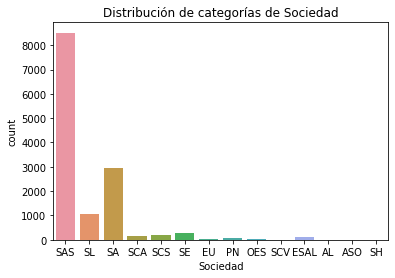

In [31]:
# Observar los recuentos del tipo de sociedad
sns.countplot(data=basicos,x="Sociedad")
plt.title("Distribución de categorías de Sociedad")
plt.show()

### Tratamiento de valores perdidos y atípicos
Solo dos columnas presentan valores perdidos en la fuente de datos. El número de filas sin informar es muy bajo en las dos variables. Por lo tanto, no es necesario dedicar un gran esfuerzo en la imputación de estos valores. Se proponen las siguientes acciones:

1. Informar del número de empleados con la media de los grupos del tamaño de empresa.
2. Informar del año de constitución con la media de la misma variable.

In [32]:
# Media de empleados según el tamaño de la empresa
basicos.groupby(['Tamanyo'])['NumEmpleados'].mean()

Tamanyo
GR    413.876448
MC      8.681529
MD     92.962778
PQ     38.788828
Name: NumEmpleados, dtype: float64

In [33]:
# Media del año de constitución
basicos['AnyoConstitucion'].mean()

1996.0589513108614

In [34]:
# Imputar los valores con la media de grupos y la media, respectivamente
basicos['NumEmpleados'].fillna(basicos.groupby(['Tamanyo'])['NumEmpleados'].transform('mean').round().astype(int), inplace=True)
basicos['AnyoConstitucion'].fillna(basicos['AnyoConstitucion'].mean().round().astype(int), inplace=True)
# Crear el nuevo dataframe con las nuevas columnas
basicos_nomissings = basicos
basicos_nomissings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                13357 non-null  int64  
 1   Tipologia         13357 non-null  object 
 2   Ciiu              13357 non-null  object 
 3   Sociedad          13357 non-null  object 
 4   Tamanyo           13357 non-null  object 
 5   Departamento      13357 non-null  object 
 6   Localidad         13357 non-null  object 
 7   NumEmpleados      13357 non-null  float64
 8   AnyoConstitucion  13357 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 939.3+ KB


Los valores atípicos son aquellas empresas con un número de empleados mucho más grande que lo normal. Estas empresas pueden significar una gran parcialidad (bias) para los algoritmos de aprendizaje automático, por lo que se deben tratar adecuadamente.

En este caso, la distribución del número de empleados es exponencial, y tiende a pocas empresas a medida que se incrementa el número de empleados. No es posible eliminar las empresas más grandes mediante el descarte según desviaciones típicas, ya que se filtrarían muchísimas empresas fuera.

Alternativamente, se podría aplicar una transformación para reducir el efecto de las empresas con un gran número de empleados. La más adecuada es la transformación logarítmica, que escala los datos utilizando un logaritmo en cualquier base. Esto reduce la gran diferencia entre los valores centrales y atípicos, y no es difícil de invertir. Además, conserva la propiedad del orden entre empresas, por lo que resulta ideal.

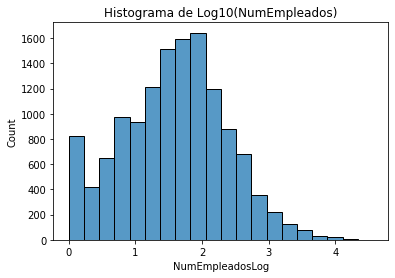

In [35]:
# Aplicar el logaritmo al número de empleados
basicos_nomissings['NumEmpleadosLog'] = basicos_nomissings['NumEmpleados'].apply(lambda x: np.log10(x))
sns.histplot(data=basicos_nomissings, x = 'NumEmpleadosLog', bins=20)
plt.title("Histograma de Log10(NumEmpleados)")
plt.show()

De esta manera se reduce el impacto de los valores atípicos. Se puede observar el pico que ocurre en las empresas con un único empleado en la banda izquierda de la distribución.

### Transformación de datos
Las transformaciones de datos buscan mejorar la calidad de los procesos de aprendizaje automático que se puedan aplicar en el futuro.

Las transformaciones propuestas son:

1. Extraer toda la información posible del código Ciiu (actividad de la empresa).
2. Obtener el número de habitantes de las localidades y discretizar los valores para deducir si son rurales o urbanos.

En primer lugar, es posible extraer la información detallada del código CIIU del departamento administrativo nacional de estadística (DANE) de Colombia. Esto se realiza en el cuaderno "Extracciones" de este mismo repositorio. La salida del cuaderno es un dataset con todas las actividades desglosadas para cada posible código CIIU.

Mediante una operación de join, es posible incorporar dicha información al dataset actual, prescindiendo de la columna del código ciiu, que deja de aportar valor.

En segundo lugar, también es posible extraer la denominación de ruralidad a partir de los datos estadísticos de la población publicados por el DANE. Esta extracción también se realiza en el mismo cuaderno mencionado anteriormente.

A continuación se cargan y enlazan los resultados con el dataset principal.

In [36]:
# Leer los datos de las extracciones
ciiu = pd.read_csv("Data/ExtraccionCIIU.csv",sep=";",encoding='utf-8', dtype={'Division': object, "Grupo":object, "Clase":object})
ciiu.head()

,Ciiu,Seccion,SeccionDesc,Division,DivisionDesc,Grupo,GrupoDesc,Clase,ClaseDesc
0,A0111,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0111,"Cultivo de cereales (excepto arroz), legumbres..."
1,A0112,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0112,Cultivo de arroz
2,A0113,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0113,"Cultivo de hortalizas, raíces y tubérculos"
3,A0114,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0114,Cultivo de tabaco
4,A0115,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P...",01,"Agricultura, ganadería, caza y actividades de ...",011,Cultivos agrícolas transitorios,0115,Cultivo de plantas textiles


Los códigos ciiu forman una estructura jerárquica con información sobre la sección, la división, el grupo y la clase de la actividad de la empresa. A continuación se pone a prueba que la operación de fusión se lleve a cabo correctamente.

In [37]:
# Juntar los datos
basicos_ciiu = basicos_nomissings.merge(ciiu, on="Ciiu",how="left")
print("Columnas de las empresas con la información detallada del código CIIU ")
basicos_ciiu.info()
# Ver que empresas tienen códigos ciiu 
print()
print("Códigos CIIU sin reconocer: {0}".format(basicos_ciiu[basicos_ciiu['Seccion'].isna()]['Ciiu'].unique()))
print("Tipologias de empresas con códigos CIIU desconocidos: {0}".format(basicos_ciiu[basicos_ciiu['Seccion'].isna()]['Tipologia'].unique()))


Columnas de las empresas con la información detallada del código CIIU 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13357 entries, 0 to 13356
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                13357 non-null  int64  
 1   Tipologia         13357 non-null  object 
 2   Ciiu              13357 non-null  object 
 3   Sociedad          13357 non-null  object 
 4   Tamanyo           13357 non-null  object 
 5   Departamento      13357 non-null  object 
 6   Localidad         13357 non-null  object 
 7   NumEmpleados      13357 non-null  float64
 8   AnyoConstitucion  13357 non-null  float64
 9   NumEmpleadosLog   13357 non-null  float64
 10  Seccion           13340 non-null  object 
 11  SeccionDesc       13340 non-null  object 
 12  Division          13340 non-null  object 
 13  DivisionDesc      13340 non-null  object 
 14  Grupo             13340 non-null  object 
 15  GrupoDesc       

Se observa que existen algunas empresas con códigos CIIU no catalogados. Todas ellas pertenecen a empresas de la tipología "Entidad sin ánimo de lucro". 

Se decide prescindir de estas filas al ser este tipo de entidades y tener un código CIIU no reconocido.

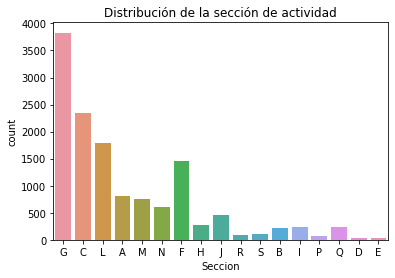

Secciones más frecuentes: 


COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS    3828
INDUSTRIAS MANUFACTURERAS                                                                   2350
ACTIVIDADES INMOBILIARIAS                                                                   1791
CONSTRUCCIÓN                                                                                1451
AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA                                           817
Name: SeccionDesc, dtype: int64

In [38]:
# Eliminar las filas detectadas
basicos_ciiu_corregido = basicos_ciiu.dropna(subset=['Seccion'])
# Gráfico de distribución de la variable sección de actividad
sns.countplot(data=basicos_ciiu_corregido, x="Seccion")
plt.title("Distribución de la sección de actividad")
plt.show()
# Secciones más frecuentes
print("Secciones más frecuentes: ")
basicos_ciiu_corregido["SeccionDesc"].value_counts()[0:5]

La sección más frecuente es el comercio al por mayor y al por menor y la reparación de automóviles (G). En segundo y tercer lugar aparecen las industrias manufactureras (C) y las actividades inmobiliarias (L). El cuarto lugar es ocupado por la construcción y el quinto por la agricultura y similares (A)

Por último, se importan los datos de la ruralidad de cada municipio en el dataset de interés y se enlazan a través de cada departamento y municipio del dataset actual.

Para que la operación de merge sea satisfactoria, será necesario corregir diferencias entre los nombres de los municipios o departamentos entre los dos juegos de datos, así como algunos errores de departamentos encontrados.

In [39]:
ruralidad = pd.read_csv("Data/ExtraccionRuralidad.csv",sep=";",encoding='utf-8')
ruralidad.head()

,Municipio,Departamento,poblacionTotal,poblacionCabecera,Superficie,CategoriaRural
0,medellin,antioquia,2427129.0,2382399.0,372.419334,Urbana
1,abejorral,antioquia,20367.0,7674.0,491.450581,Rural
2,abriaqui,antioquia,2695.0,824.0,288.302005,Rural disperso
3,alejandria,antioquia,4657.0,2485.0,135.591868,Rural
4,amaga,antioquia,30227.0,14184.0,85.215263,Intermedia


In [40]:
# Deshabilitar warnings por asignación en copia
pd.set_option('mode.chained_assignment', None)
# Crear las nuevas columnas para la operación de merge
basicos_ciiu_corregido['MunicipioMerge'] = basicos_ciiu_corregido.apply(lambda x: unidecode.unidecode(x['Localidad']).lower().strip(), axis=1)
basicos_ciiu_corregido['DepartamentoMerge'] = basicos_ciiu_corregido.apply(lambda x: unidecode.unidecode(x['Departamento']).lower().strip(), axis=1)

# Cambiar el nombre de las columnas del dataset importado
ruralidad = ruralidad.rename(columns={'Municipio': 'MunicipioMerge', 'Departamento': 'DepartamentoMerge'})

# Poner en acorde los nombres de los departamentos que difieren
ruralidad.at[ruralidad['DepartamentoMerge'] == 'valle del cauca','DepartamentoMerge'] = 'valle'
ruralidad.at[ruralidad['DepartamentoMerge'] == 'norte de santander','DepartamentoMerge'] = 'norte santander'
# Poner en acorde los nombres de los municipios que difieren
ruralidad.at[ruralidad['MunicipioMerge'] == 'villa de san diego de ubate','MunicipioMerge'] = 'ubate'
ruralidad.at[ruralidad['MunicipioMerge'] == 'guadalajara de buga','MunicipioMerge'] = 'buga'
ruralidad.at[ruralidad['MunicipioMerge'] == 'villa del rosario','MunicipioMerge'] = 'villa rosario'
ruralidad.at[ruralidad['MunicipioMerge'] == 'el carmen de viboral', 'MunicipioMerge'] = 'carmen de viboral'
# Corregir los datos erróneos de las poblaciones del dataset de las superintendencias
basicos_ciiu_corregido.at[(basicos_ciiu_corregido['MunicipioMerge'] == 'mosquera') & (basicos_ciiu_corregido['DepartamentoMerge'] == 'bogota'),'DepartamentoMerge'] = 'cundinamarca'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'bogota','DepartamentoMerge'] = 'bogota'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'cota' ,'DepartamentoMerge'] = 'cundinamarca'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'san pablo' ,'DepartamentoMerge'] = 'narino'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'manizales' ,'DepartamentoMerge'] = 'caldas'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'madrid' ,'DepartamentoMerge'] = 'cundinamarca'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'guasca' ,'DepartamentoMerge'] = 'cundinamarca'
basicos_ciiu_corregido.at[basicos_ciiu_corregido['MunicipioMerge'] == 'cali' ,'DepartamentoMerge'] = 'valle'
# Eliminar los municipios no existentes en colombia
basicos_ciiu_corregido = basicos_ciiu_corregido[basicos_ciiu_corregido['MunicipioMerge'] != 'chicago']
basicos_ciiu_corregido = basicos_ciiu_corregido[basicos_ciiu_corregido['MunicipioMerge'] != 'sao paulo']
# Empresa erronea con localidad en valle (cuando es un departamento). Se elimina del dataset ya que es sin ánimo de lucro igualmente
basicos_ciiu_corregido = basicos_ciiu_corregido[basicos_ciiu_corregido['MunicipioMerge'] != 'valle']

# Operación de merge y observación de las nuevas columnas
mergeResult = basicos_ciiu_corregido.merge(ruralidad, on=['MunicipioMerge','DepartamentoMerge'], how='left')
mergeResult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13337 entries, 0 to 13336
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 13337 non-null  int64  
 1   Tipologia          13337 non-null  object 
 2   Ciiu               13337 non-null  object 
 3   Sociedad           13337 non-null  object 
 4   Tamanyo            13337 non-null  object 
 5   Departamento       13337 non-null  object 
 6   Localidad          13337 non-null  object 
 7   NumEmpleados       13337 non-null  float64
 8   AnyoConstitucion   13337 non-null  float64
 9   NumEmpleadosLog    13337 non-null  float64
 10  Seccion            13337 non-null  object 
 11  SeccionDesc        13337 non-null  object 
 12  Division           13337 non-null  object 
 13  DivisionDesc       13337 non-null  object 
 14  Grupo              13337 non-null  object 
 15  GrupoDesc          13337 non-null  object 
 16  Clase              133

La operación de merge es satisfactoria e informa correctamente de la categoría rural de todas las empresas del dataset. Por último, se renombran las columnas y se eliminan aquellas que no aportan valor:

* Descripciones de la actividad de la empresa. El código de la actividad desglosado representa la misma información.
* Número de habitantes y superficie del municipio. Ya se cuenta con la categoría rural de cada municipio, que es un dato derivado de estos.
* Código CIIU. No resulta interesante tener el código compacto para cada empresa, aporta más valor su desglose en nuevas columnas.
* Columnas varias como los índices de los datasets de extracción.

In [41]:
# Columnas a preservar
columnas = ['Id','Tipologia','Sociedad','NumEmpleadosLog', 'Tamanyo','DepartamentoMerge','MunicipioMerge','AnyoConstitucion',\
           'Seccion','Division','Grupo','Clase','CategoriaRural']

# Renombrar columnas
seleccion = mergeResult[columnas]
seleccion = seleccion.rename(columns={'DepartamentoMerge': 'Departamento', 'MunicipioMerge': 'Municipio'})

# Asignar tipos correctamente
seleccion = seleccion.astype({"AnyoConstitucion": int, "Division":str, "Grupo":str, "Clase":str})
seleccion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13337 entries, 0 to 13336
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                13337 non-null  int64  
 1   Tipologia         13337 non-null  object 
 2   Sociedad          13337 non-null  object 
 3   NumEmpleadosLog   13337 non-null  float64
 4   Tamanyo           13337 non-null  object 
 5   Departamento      13337 non-null  object 
 6   Municipio         13337 non-null  object 
 7   AnyoConstitucion  13337 non-null  int32  
 8   Seccion           13337 non-null  object 
 9   Division          13337 non-null  object 
 10  Grupo             13337 non-null  object 
 11  Clase             13337 non-null  object 
 12  CategoriaRural    13337 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 1.4+ MB


In [42]:
# Guardar los datos
seleccion.to_csv("data/DatosEmpresaClean.csv", sep=";", encoding="utf-8", index=False)